In [9]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from textblob import TextBlob
from tqdm import tqdm
import re

folder = "data"

rs_files = [f for f in os.listdir(folder) if f.startswith("RS") and f.endswith(".csv")]
rc_files = [f for f in os.listdir(folder) if f.startswith("RC") and f.endswith(".csv")]

def get_common_columns(files):
    common_cols = None
    for filename in files:
        path = os.path.join(folder, filename)
        df = pd.read_csv(path, nrows=0)
        cols = set(df.columns)
        if common_cols is None:
            common_cols = cols
        else:
            common_cols |= cols
    return common_cols or set()

rs_common = get_common_columns(rs_files)
rc_common = get_common_columns(rc_files)

print("Common columns in RS files:", rs_common)
print("Common columns in RC files:", rc_common)

print("Total number of columns in RS files:", len(rs_common))
print("Total number of columns in RC files:", len(rc_common))

Common columns in RS files: {'ups', 'all_awardings', 'media_embed', 'domain', 'view_count', 'saved', 'can_gild', 'media_only', 'contest_mode', 'likes', 'is_meta', 'wls', 'parent_whitelist_status', 'subreddit_id', 'score', 'downs', 'is_video', 'category', 'gallery_data', 'permalink', 'author_flair_template_id', 'over_18', 'author_flair_type', 'stickied', 'treatment_tags', 'allow_live_comments', 'link_flair_text_color', 'num_reports', 'link_flair_text', 'removed_by_category', 'removal_reason', 'author', 'crosspost_parent_list', 'subreddit', 'report_reasons', 'author_flair_text_color', 'user_reports', 'is_original_content', 'media_metadata', 'hide_score', 'url', 'created', 'is_reddit_media_domain', 'link_flair_css_class', 'selftext', 'total_awards_received', 'is_gallery', 'spoiler', 'media', 'retrieved_on', 'can_mod_post', 'pinned', '_meta', 'is_robot_indexable', 'preview', 'mod_note', 'secure_media_embed', 'upvote_ratio', 'author_is_blocked', 'whitelist_status', 'locked', 'is_crosspostab

First we need to load data and find out which columns will we use for analysis. Reddit submissions contains 120 columns and comments 74. Obviously we won't use them all, so we need to choose the most important.

In [10]:
rs_columns = ['id', 'author', 'created_utc', 'subreddit', 'title', 'selftext',
 'link_flair_text', 'domain', 'score', 'ups', 'downs', 'num_comments',
 'upvote_ratio', 'total_awards_received', 'retrieved_on', 'is_original_content']

rc_columns = ['id', 'author', 'created_utc', 'subreddit', 'body', 'score',
 'ups', 'downs', 'parent_id', 'link_id', 'is_submitter', 
 'controversiality', 'total_awards_received', 'retrieved_on']

We decided to leave those columns as they give us almost all information we need to conduct our analysis and get some meaningful results. We may alter these during our experiments and analysis.

In [11]:
def read_subset(file, columns, source_type):
    path = os.path.join(folder, file)
    try:
        df = pd.read_csv(path, usecols=lambda c: c in columns)
        df = df.reindex(columns=columns)
        df["source_type"] = source_type
        return df
    except Exception as e:
        return pd.DataFrame(columns=columns + ["source_type"])

if not os.path.exists("preprocessed/reddit_submissions_filtered.csv") or not os.path.exists("preprocessed/reddit_comments_filtered.csv"):
    rs_dfs = [read_subset(f, rs_columns, "submission") for f in rs_files]
    rc_dfs = [read_subset(f, rc_columns, "comment") for f in rc_files]

In [12]:
if not os.path.exists("preprocessed/reddit_submissions_filtered.csv"):
    submissions_df = pd.concat(rs_dfs, ignore_index=True)
    submissions_df.to_csv("preprocessed/reddit_submissions_filtered.csv", index=False)
else:
    submissions_df = pd.read_csv("preprocessed/reddit_submissions_filtered.csv")

if not os.path.exists("preprocessed/reddit_comments_filtered.csv"):
    comments_df = pd.concat(rc_dfs, ignore_index=True)
    comments_df.to_csv("preprocessed/reddit_comments_filtered.csv", index=False)
else:
    comments_df = pd.read_csv("preprocessed/reddit_comments_filtered.csv")
    comments_df = comments_df[comments_df['created_utc'] > 1704116554]

In [13]:
print(f"Submissions DataFrame: {len(submissions_df):,} rows, {len(submissions_df.columns)} columns")
print(f"Comments DataFrame: {len(comments_df):,} rows, {len(comments_df.columns)} columns")

Submissions DataFrame: 355,382 rows, 17 columns
Comments DataFrame: 11,613,821 rows, 15 columns


In [14]:
if not os.path.exists("preprocessed/reddit_combined.csv"):
    comments_df["link_id_clean"] = comments_df["link_id"].str.replace("t3_", "", regex=False)
    
    joined_df = comments_df.merge(
        submissions_df,
        left_on="link_id_clean",
        right_on="id",
        suffixes=("_comment", "_submission")
    )
    
    joined_df.to_csv("preprocessed/reddit_combined.csv", index=False)

In [15]:
joined_df = pd.read_csv("preprocessed/reddit_combined.csv")

Ok, so now that we have our data filtered we can start exploring our data more thoroughly.
We will mainly explore both datasets simultaneously, applying quite similar changes. 
To begin, we need to filter out data that has nothing to do with elections. We will use keyword search and filter out data that doesn't have none of next keywords.

In [16]:
if not os.path.exists("processed/election_submissions.csv") or not os.path.exists("processed/election_comments.csv"):
    keywords = [
            'election', 'élection', 'vote', 'scrutin', 'voting', 'voter', 'ballots', 'bulletins de vote',
            'campaign', 'campagne', 'polls', 'sondages', 'polling', 'sondage', 'debate', 'débat',
            'liberal', 'libéral', 'conservative', 'conservateur', 'ndp', 'npd', 'bloc', 'bloc québécois',
            'green party', 'parti vert', 'ppc', 'ppc', "people's party", 'parti populaire',
            'carney', 'mark carney', 'trudeau', 'justin trudeau', 'prime minister', 'premier ministre',
            'leadership race', 'course à la direction', 'minority government', 'gouvernement minoritaire',
            'majority government', 'gouvernement majoritaire', 'coalition', 'coalition',
            'confidence vote', 'vote de confiance', 'cabinet', 'cabinet', 'mp', 'député',
            'riding', 'circonscription', 'parliament', 'parlement', 'candidate', 'candidat',
            'seat', 'siège', 'platform', 'plateforme', 'policy', 'politique', 'promises', 'promesses',
            'trump', 'usa', 'états-unis', 'united states', 'amérique', 'america', 'american', 'américain',
            'tariffs', 'tarifs', 'trade war', 'guerre commerciale', 'annexation', 'annexion',
            'border', 'frontière', 'nafta', 'alena', 'usmca', 'aléna', 'foreign policy', 'politique étrangère',
            'sanctions', 'sanctions', 'biden', 'washington', 'white house', 'maison blanche',
            'congress', 'congrès', 'inflation', 'inflation', 'economy', 'économie', 'housing', 'logement',
            'immigration', 'immigration', 'refugees', 'réfugiés', 'carbon tax', 'taxe carbone',
            'climate change', 'changement climatique', 'healthcare', 'soins de santé', 'indigenous', 'autochtone',
            'reconciliation', 'réconciliation', 'gun control', 'contrôle des armes à feu',
            'freedom convoy', 'convoi de la liberté', 'protest', 'protestation', 'corruption', 'corruption',
            'scandal', 'scandale', 'china', 'chine', 'russia', 'russie', 'ukraine', 'ukraine',
            'nato', 'otan', 'defense', 'défense', 'war', 'guerre'
    ]
    
    pattern = re.compile('|'.join([re.escape(k) for k in keywords]), flags=re.IGNORECASE)
    
    election_submissions = submissions_df[
        submissions_df['title'].fillna('').str.contains(pattern) |
        submissions_df['selftext'].fillna('').str.contains(pattern)
    ]
    election_comments = comments_df[
        comments_df['body'].fillna('').str.contains(pattern)
    ]

    def get_sentiment_tb(text):
        if pd.isna(text):
            return 0
        return TextBlob(text).sentiment.polarity
    
    election_comments['sentiment_score'] = election_comments['body'].apply(get_sentiment_tb)
    election_submissions['sentiment_score'] = election_submissions['full_text'].apply(get_sentiment_tb)
    
    nlp_en = spacy.load("en_core_web_sm")
    nlp_fr = spacy.load("fr_core_news_sm")
    
    from langdetect import detect, LangDetectException
    
    def extract_entities(text, nlp_en, nlp_fr):
        try:
            lang = detect(text) if text else 'en'
        except LangDetectException:
            lang = 'en'
        
        nlp = nlp_fr if lang == 'fr' else nlp_en
        doc = nlp(text)
        people = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
        places = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
        return ", ".join(people), ", ".join(places)
    
    texts = election_submissions['full_text'].tolist()
    people_list, places_list = [], []
    
    for text in tqdm(texts, total=len(texts)):
        people, places = extract_entities(text, nlp_en, nlp_fr)
        people_list.append(people)
        places_list.append(places)

    election_submissions['people'] = people_list
    election_submissions['places'] = places_list
    
    texts = election_comments['body'].tolist()
    people_list, places_list = [], []
    
    for text in tqdm(texts, total=len(texts)):
        people, places = extract_entities(text, nlp_en, nlp_fr)
        people_list.append(people)
        places_list.append(places)

    election_comments['people'] = people_list
    election_comments['places'] = places_list
    
    election_submissions.to_csv("processed/election_submissions.csv", index=False)
    election_comments.to_csv("processed/election_comments.csv", index=False)

KeyboardInterrupt: 

In [ ]:
election_submissions = pd.read_csv("processed/election_submissions.csv")
election_comments = pd.read_csv("processed/election_comments.csv")
election_comments = election_comments[election_comments['created_utc'] > 1704116554]

First, let's see how the dynamic between election related and other topics changed over time

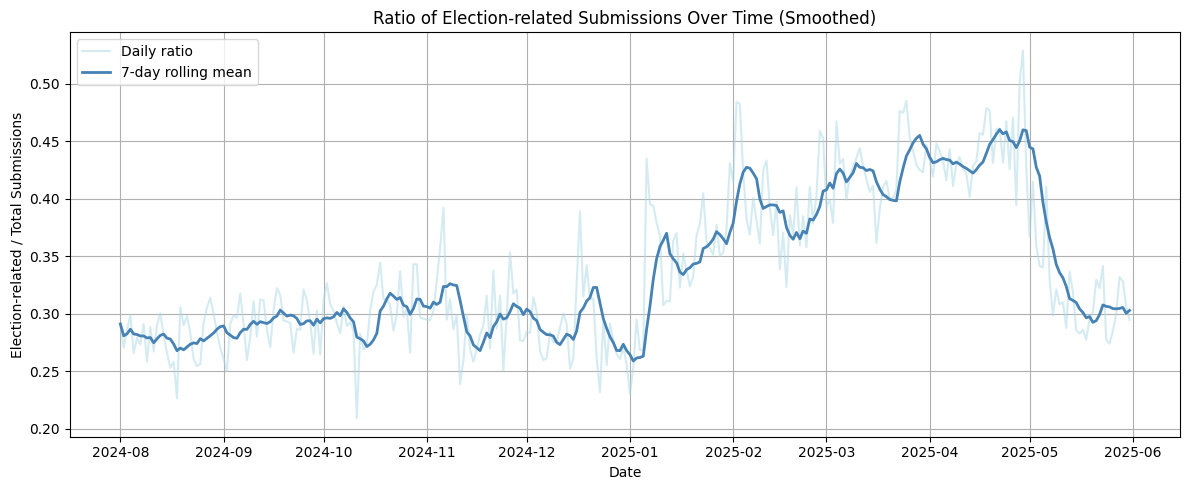

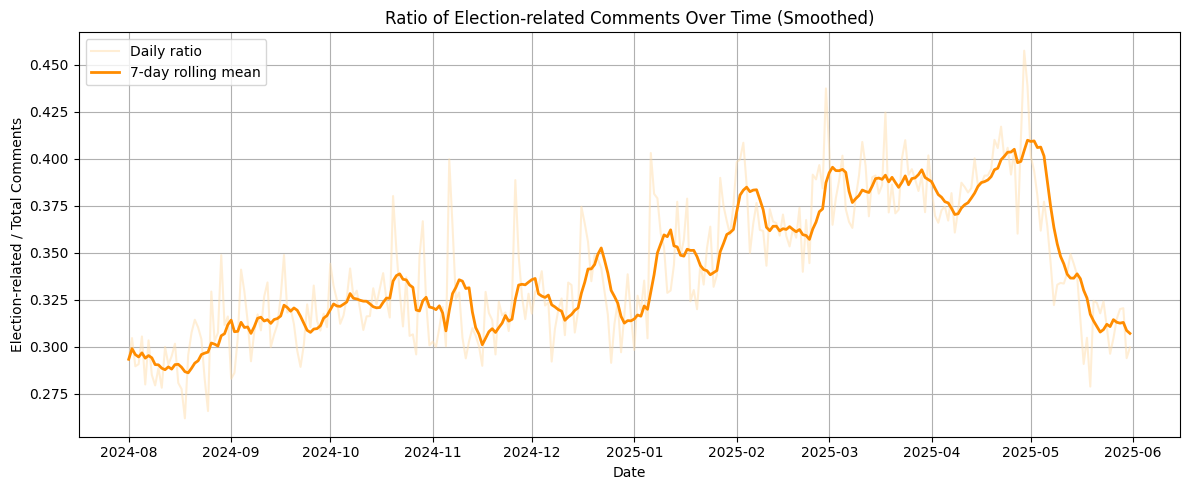

In [ ]:
for df in [election_submissions, election_comments, submissions_df, comments_df]:
    df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')

submissions_daily = (
    submissions_df.groupby(pd.Grouper(key='created_utc', freq='D'))
    .size()
    .rename('total_submissions')
)

election_submissions_daily = (
    election_submissions.groupby(pd.Grouper(key='created_utc', freq='D'))
    .size()
    .rename('election_submissions')
)

comments_daily = (
    comments_df.groupby(pd.Grouper(key='created_utc', freq='D'))
    .size()
    .rename('total_comments')
)

election_comments_daily = (
    election_comments.groupby(pd.Grouper(key='created_utc', freq='D'))
    .size()
    .rename('election_comments')
)

submissions_trend = pd.concat([submissions_daily, election_submissions_daily], axis=1).fillna(0)
comments_trend = pd.concat([comments_daily, election_comments_daily], axis=1).fillna(0)

submissions_trend['ratio'] = submissions_trend['election_submissions'] / submissions_trend['total_submissions']
comments_trend['ratio'] = comments_trend['election_comments'] / comments_trend['total_comments']

submissions_trend['ratio_smooth'] = submissions_trend['ratio'].rolling(window=7, min_periods=1).mean()
comments_trend['ratio_smooth'] = comments_trend['ratio'].rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(12, 5))
plt.plot(submissions_trend.index, submissions_trend['ratio'], color='lightblue', alpha=0.5, label='Daily ratio')
plt.plot(submissions_trend.index, submissions_trend['ratio_smooth'], color='steelblue', linewidth=2, label='7-day rolling mean')
plt.title('Ratio of Election-related Submissions Over Time (Smoothed)')
plt.xlabel('Date')
plt.ylabel('Election-related / Total Submissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(comments_trend.index, comments_trend['ratio'], color='navajowhite', alpha=0.5, label='Daily ratio')
plt.plot(comments_trend.index, comments_trend['ratio_smooth'], color='darkorange', linewidth=2, label='7-day rolling mean')
plt.title('Ratio of Election-related Comments Over Time (Smoothed)')
plt.xlabel('Date')
plt.ylabel('Election-related / Total Comments')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

From this plot we can clearly see that topicality of elections increases as  time to elections reduces. We also see different spikes(e.g. Trump inauguration), which are expected as they increased political and elections debate.
We can also notice that comments have higher ratio, which could be explained by the fact that politics is more controverisial topic than cats dogs or canadian forests.

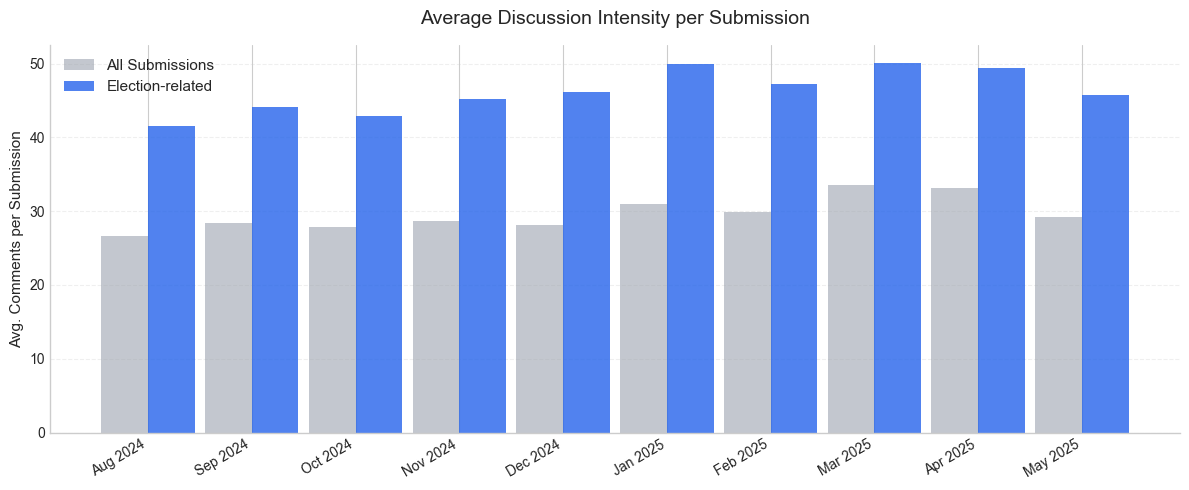

In [ ]:
submissions_df['created_utc'] = pd.to_datetime(submissions_df['created_utc'], unit='s', errors='coerce')

submissions_df['is_election_related'] = submissions_df['id'].isin(election_submissions['id'])

monthly_total_avg = (
    submissions_df.groupby(pd.Grouper(key='created_utc', freq='M'))['num_comments']
    .mean()
    .rename('All Submissions')
)
monthly_election_avg = (
    submissions_df[submissions_df['is_election_related']]
    .groupby(pd.Grouper(key='created_utc', freq='M'))['num_comments']
    .mean()
    .rename('Election-related')
)

monthly_avg_comments = pd.concat([monthly_total_avg, monthly_election_avg], axis=1).fillna(0)

plt.figure(figsize=(12, 5))
plt.style.use('seaborn-v0_8-whitegrid')

x = np.arange(len(monthly_avg_comments))
width = 0.45

plt.bar(x - width/2, monthly_avg_comments['All Submissions'], width,
        label='All Submissions', color='#9CA3AF', alpha=0.6)
plt.bar(x + width/2, monthly_avg_comments['Election-related'], width,
        label='Election-related', color='#2563EB', alpha=0.8)

plt.xticks(x, monthly_avg_comments.index.strftime('%b %Y'), rotation=30, ha='right')
plt.ylabel('Avg. Comments per Submission', fontsize=11)
plt.title('Average Discussion Intensity per Submission', fontsize=14, pad=15)
plt.legend(frameon=False, fontsize=11)

plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.gca().spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

Looking at the barchart, we can clearly see that election-related submissions received greater number of comments on average throughout all research period.
Now, let's take a look at one more thing: let's look at dynamics of upvotes, downvotes and score of posts on average.

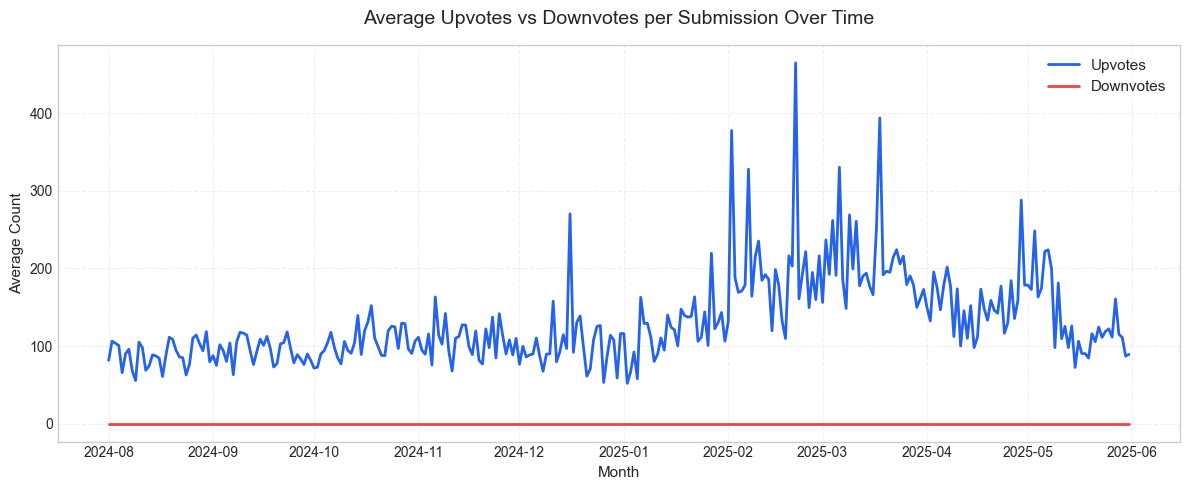

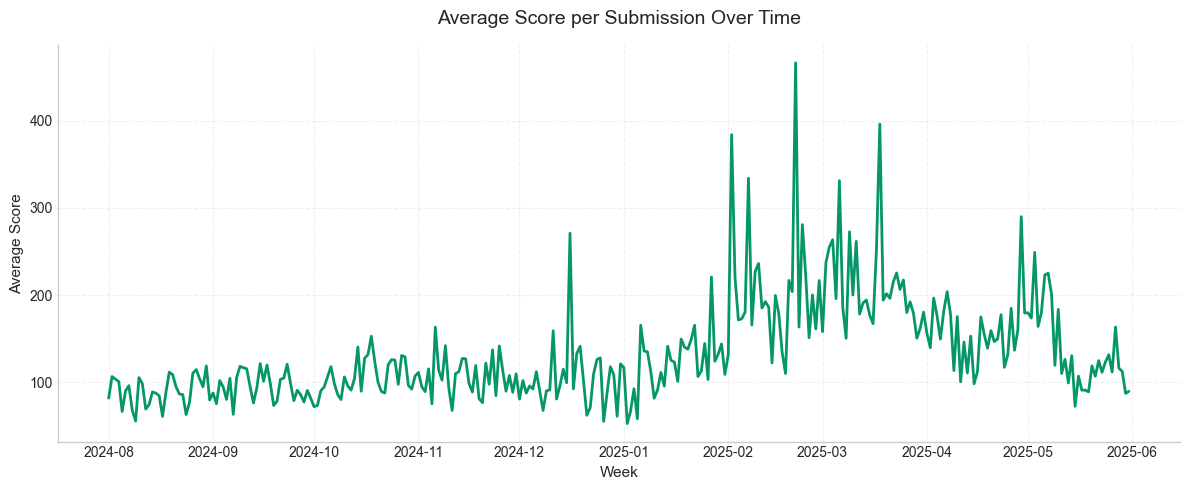

In [ ]:
election_submissions['created_utc'] = pd.to_datetime(election_submissions['created_utc'], unit='s', errors='coerce')

monthly_metrics = (
    election_submissions
    .groupby(pd.Grouper(key='created_utc', freq='d'))[['ups', 'downs', 'score']]
    .mean()
)

plt.figure(figsize=(12, 5))
plt.plot(monthly_metrics.index, monthly_metrics['ups'], label='Upvotes', color='#2563EB', linewidth=2)
plt.plot(monthly_metrics.index, monthly_metrics['downs'], label='Downvotes', color='#EF4444', linewidth=2)

plt.title('Average Upvotes vs Downvotes per Submission Over Time', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=11)
plt.ylabel('Average Count', fontsize=11)
plt.legend(frameon=False, fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(monthly_metrics.index, monthly_metrics['score'], color='#059669', linewidth=2)

plt.title('Average Score per Submission Over Time', fontsize=14, pad=15)
plt.xlabel('Week', fontsize=11)
plt.ylabel('Average Score', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

To be honest, these graphs weren't as informative as I thought they would be. Anyway, we discovered that there is no stats on downs as reddit hid them several years ago. We can nevertheless try to extract info on both conservatives and liberals from election dataframe and look how they scored throughout campaign. 

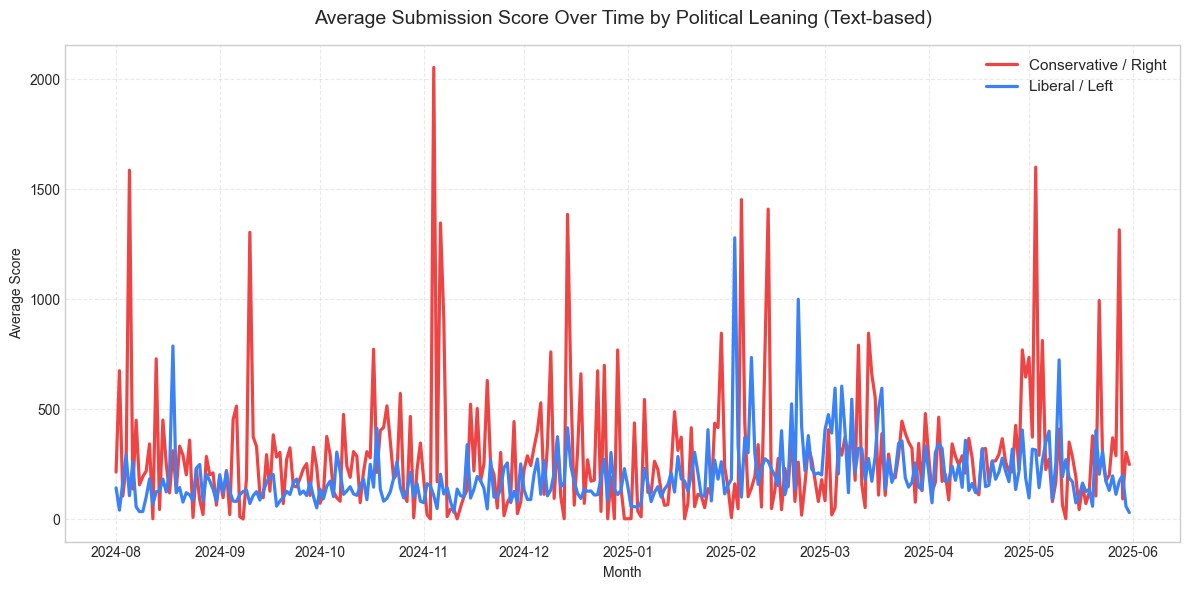

In [ ]:
election_submissions['created_utc'] = pd.to_datetime(election_submissions['created_utc'], unit='s', errors='coerce')

election_submissions['full_text'] = (
    (election_submissions['title'].fillna('') + ' ' + election_submissions['selftext'].fillna('')).str.lower()
)

liberal_keywords = [
    'liberal', 'trudeau', 'mark carney', 'freeland', 'ndp', 'green party', 
    'progressive', 'left-wing', 'liberals', 'canada liberals'
]

conservative_keywords = [
    'conservative', 'poilievre', 'right-wing', 'tory', 'ppc', 
    'peoples party', 'reform party', 'harper'
]

def categorize_text(text):
    text = text.lower()
    if any(re.search(rf'\b{kw}\b', text) for kw in liberal_keywords):
        return 'Liberal / Left'
    elif any(re.search(rf'\b{kw}\b', text) for kw in conservative_keywords):
        return 'Conservative / Right'

election_submissions['political_category'] = election_submissions['full_text'].apply(categorize_text)

score_trends = (
    election_submissions.groupby([pd.Grouper(key='created_utc', freq='d'), 'political_category'])['score']
    .mean()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 6))

colors = {
    'Liberal / Left': '#3B82F6',
    'Conservative / Right': '#EF4444',
}

for col in score_trends.columns:
    plt.plot(score_trends.index, score_trends[col],
             label=col,
             linewidth=2.3,
             color=colors.get(col, '#000000'))

plt.title('Average Submission Score Over Time by Political Leaning (Text-based)', fontsize=14, pad=15)
plt.xlabel('Month')
plt.ylabel('Average Score')
plt.legend(frameon=False, fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

One more thing we can visualize is controversality rates

In [ ]:
election_comments

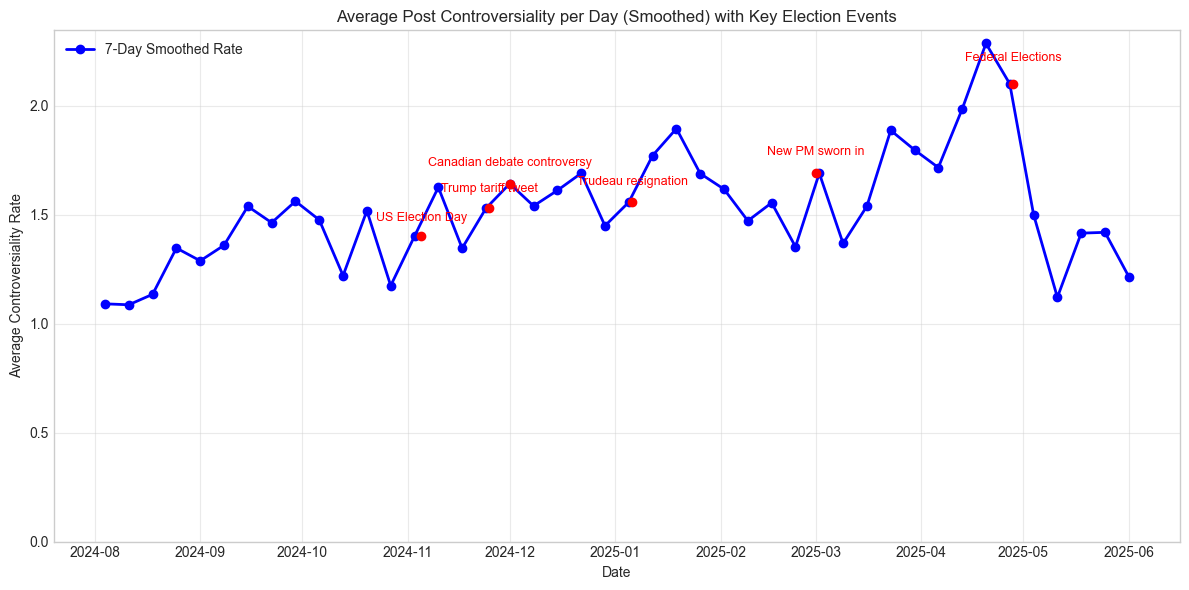

In [ ]:
controversiality_by_post = (
    election_comments.groupby("link_id")
      .agg(
          controversiality_rate=("controversiality", "sum"),
          created_utc=("created_utc", "min")
      )
      .reset_index()
      .sort_values("created_utc")
)

daily_controversiality = (
    controversiality_by_post
    .set_index("created_utc")
    .resample("W")["controversiality_rate"]
    .mean()
    .reset_index()
)
events = [
    ("2024-11-05", "US Election Day"),
    ("2024-11-25", "Trump tariff tweet"),
    ("2024-12-01", "Canadian debate controversy"),
    ("2025-01-06", "Trudeau resignation"),
    ("2025-03-01", "New PM sworn in"),
    ("2025-04-28", "Federal Elections")
]

plt.figure(figsize=(12,6))

plt.plot(
    daily_controversiality["created_utc"],
    daily_controversiality["controversiality_rate"],
    color="blue", linewidth=2, marker="o", label="7-Day Smoothed Rate"
)

for date_str, label in events:
    date = pd.to_datetime(date_str)
    nearest_idx = (daily_controversiality["created_utc"] - date).abs().idxmin()
    y = daily_controversiality.loc[nearest_idx, "controversiality_rate"]
    plt.scatter(date, y, color="red", zorder=5)
    plt.text(date, y * 1.05, label, color="red", ha="center", fontsize=9)

plt.title("Average Post Controversiality per Day (Smoothed) with Key Election Events")
plt.xlabel("Date")
plt.ylabel("Average Controversiality Rate")
plt.grid(True, alpha=0.4)
plt.legend()
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

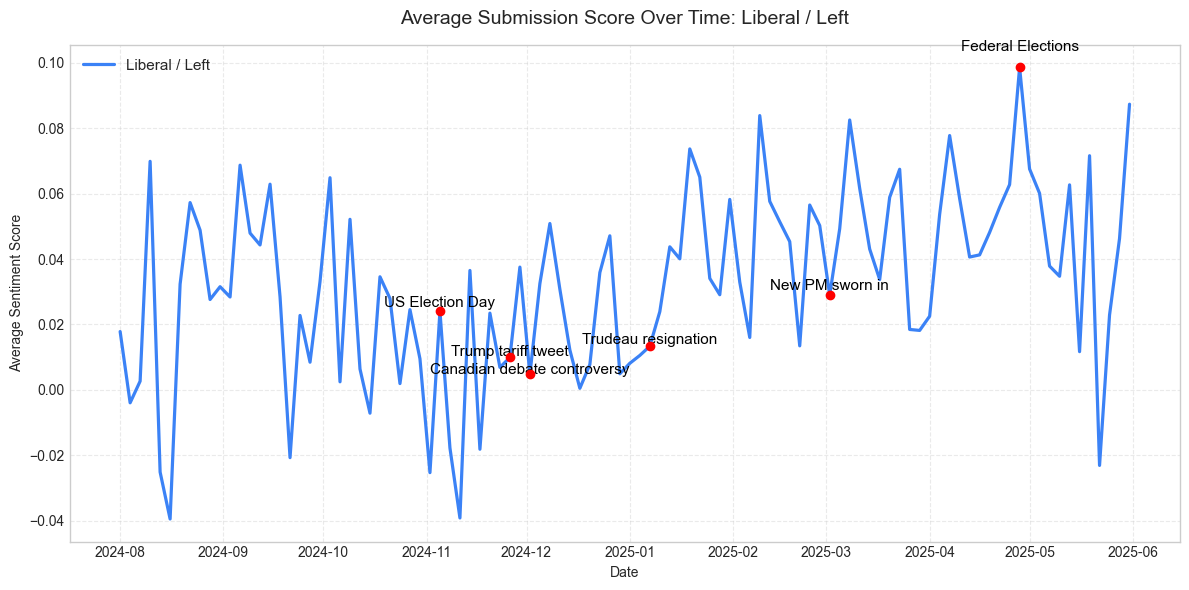

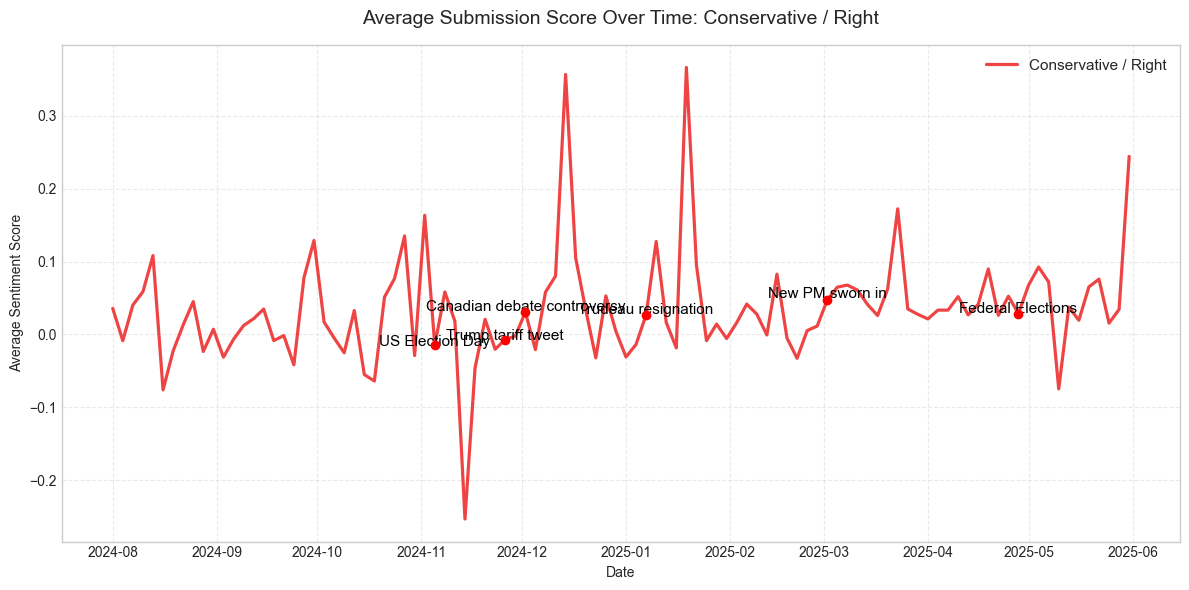

In [ ]:
score_trends = (
    election_submissions.groupby([pd.Grouper(key='created_utc', freq='3D'), 'political_category'])['sentiment_score']
    .mean()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 6))

colors = {
    'Liberal / Left': '#3B82F6',
    'Conservative / Right': '#EF4444',
}

events = [
    ("2024-11-05", "US Election Day"),
    ("2024-11-25", "Trump tariff tweet"),
    ("2024-12-01", "Canadian debate controversy"),
    ("2025-01-06", "Trudeau resignation"),
    ("2025-03-01", "New PM sworn in"),
    ("2025-04-28", "Federal Elections")
]

for category in ['Liberal / Left', 'Conservative / Right']:
    plt.figure(figsize=(12, 6))
    
    plt.plot(score_trends.index, score_trends[category],
             label=category,
             linewidth=2.3,
             color=colors.get(category, '#000000'))
    
    for date_str, label in events:
        date = pd.to_datetime(date_str)
        nearest_idx_array = score_trends.index.get_indexer([date], method='nearest')
        nearest_idx = nearest_idx_array[0]
        y = score_trends.iloc[nearest_idx][category]
        plt.scatter(score_trends.index[nearest_idx], y, color="red", zorder=5)
        plt.text(score_trends.index[nearest_idx], y * 1.05, label, color="black", ha="center", fontsize=11)
    
    plt.title(f'Average Submission Score Over Time: {category}', fontsize=14, pad=15)
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.legend(frameon=False, fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

Most Popular People:
mark carney: 2362
trudeau: 1831
donald trump: 1259
doug ford: 1093
carney: 1050
\-: 794
trump: 578
justin trudeau: 525
danielle smith: 512
de la: 286
smith: 269
bien: 259
d'un: 248
pierre poilievre: 226
hamilton: 213
eu: 211
il: 210
john: 195
ce qui: 192
max: 187

Most Popular Places:
canada: 22520
toronto: 4562
u.s.: 3945
calgary: 3648
ottawa: 3644
america: 2884
us: 2777
china: 1759
alberta: 1524
b.c.: 1408
n’t: 954
the united states: 879
saskatchewan: 863
singh: 821
russia: 731
la: 642
mexico: 625
ukraine: 508
france: 500
washington: 494


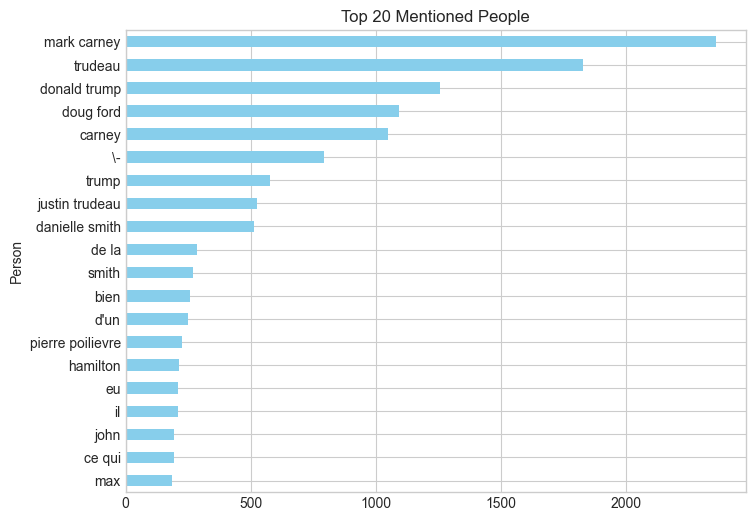

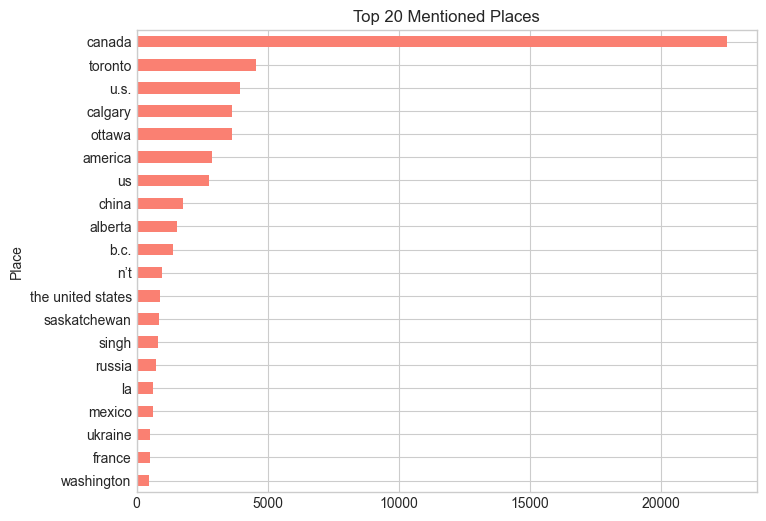

In [ ]:
from collections import Counter

# Flatten all people
all_people = election_submissions['people'].dropna().str.split(', ')
all_people_flat = [person for sublist in all_people for person in sublist if person]

# Flatten all places
all_places = election_submissions['places'].dropna().str.split(', ')
all_places_flat = [place for sublist in all_places for place in sublist if place]


people_counter = Counter(all_people_flat)
places_counter = Counter(all_places_flat)

# Most common people and places
most_common_people = people_counter.most_common(20)  # top 20
most_common_places = places_counter.most_common(20)  # top 20

print("Most Popular People:")
for person, count in most_common_people:
    print(f"{person}: {count}")

print("\nMost Popular Places:")
for place, count in most_common_places:
    print(f"{place}: {count}")


top_people_df = pd.DataFrame(most_common_people, columns=['Person', 'Count'])
top_places_df = pd.DataFrame(most_common_places, columns=['Place', 'Count'])

# Example: bar plot
top_people_df.plot.barh(x='Person', y='Count', figsize=(8,6), color='skyblue', legend=False)
plt.gca().invert_yaxis()
plt.title("Top 20 Mentioned People")
plt.show()

top_places_df.plot.barh(x='Place', y='Count', figsize=(8,6), color='salmon', legend=False)
plt.gca().invert_yaxis()
plt.title("Top 20 Mentioned Places")
plt.show()


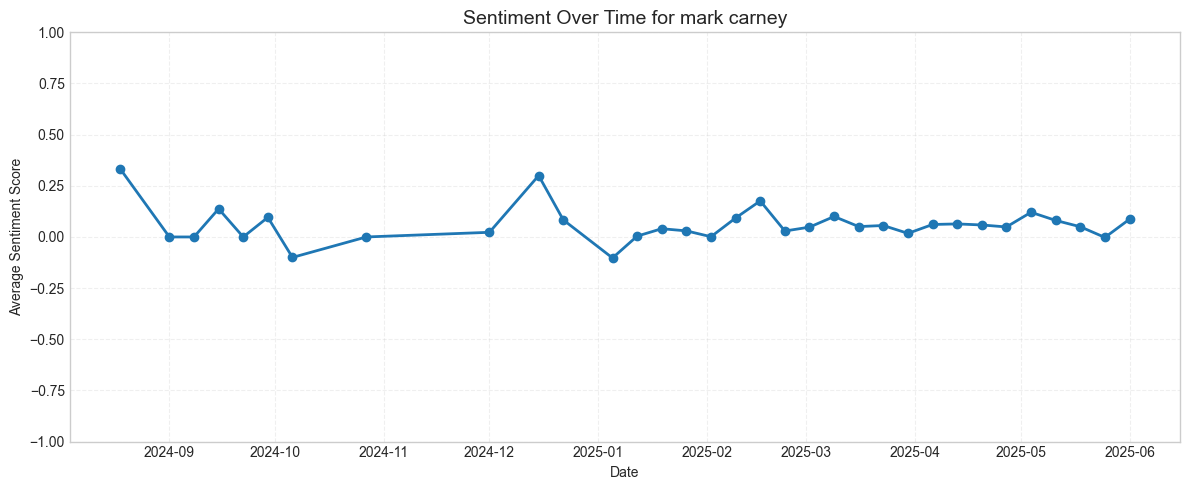

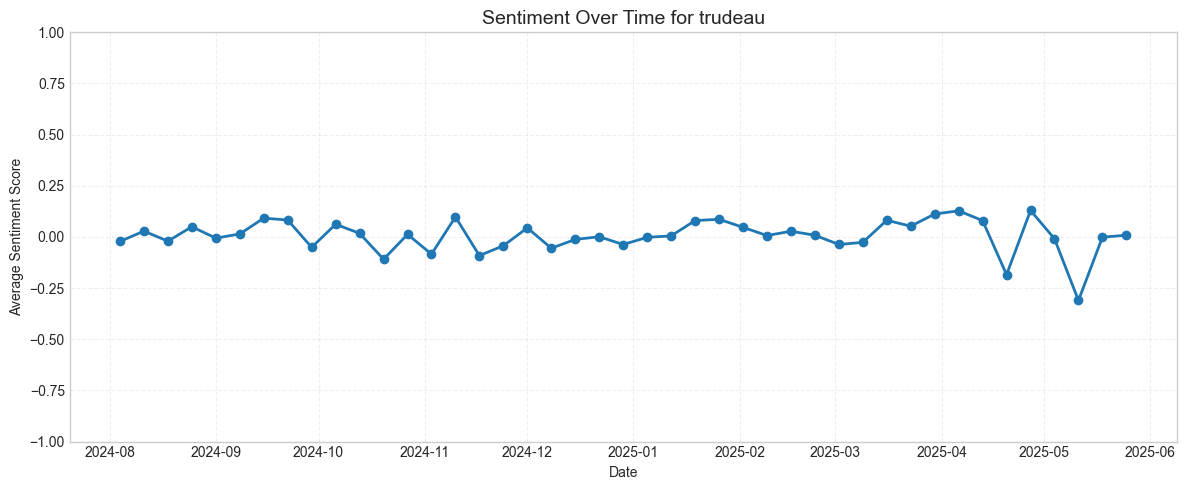

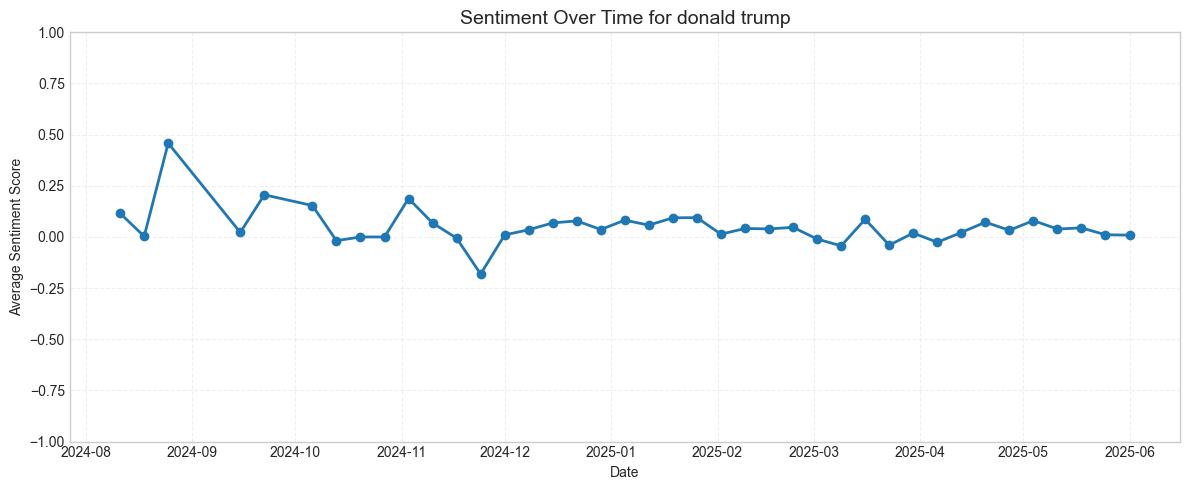

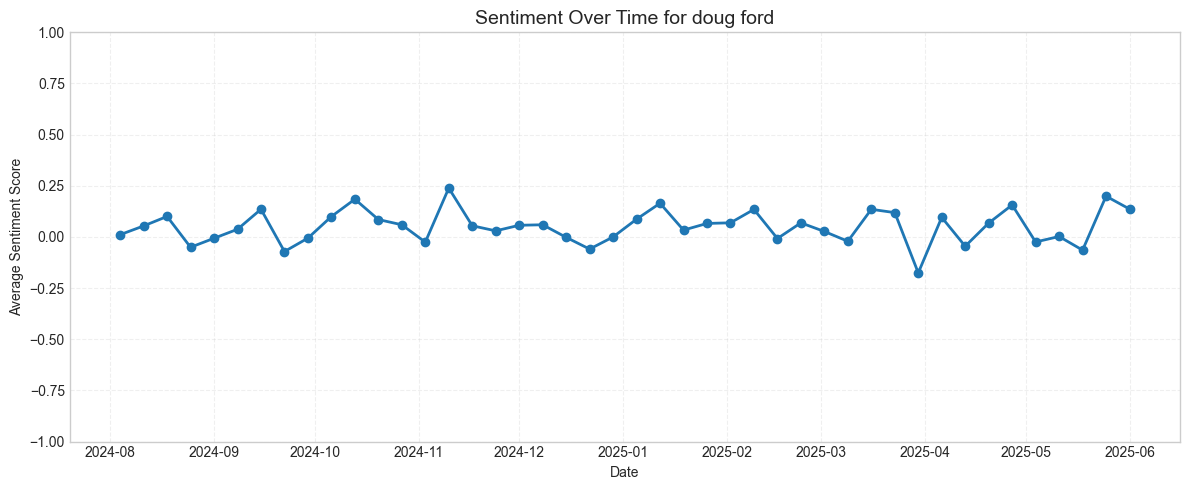

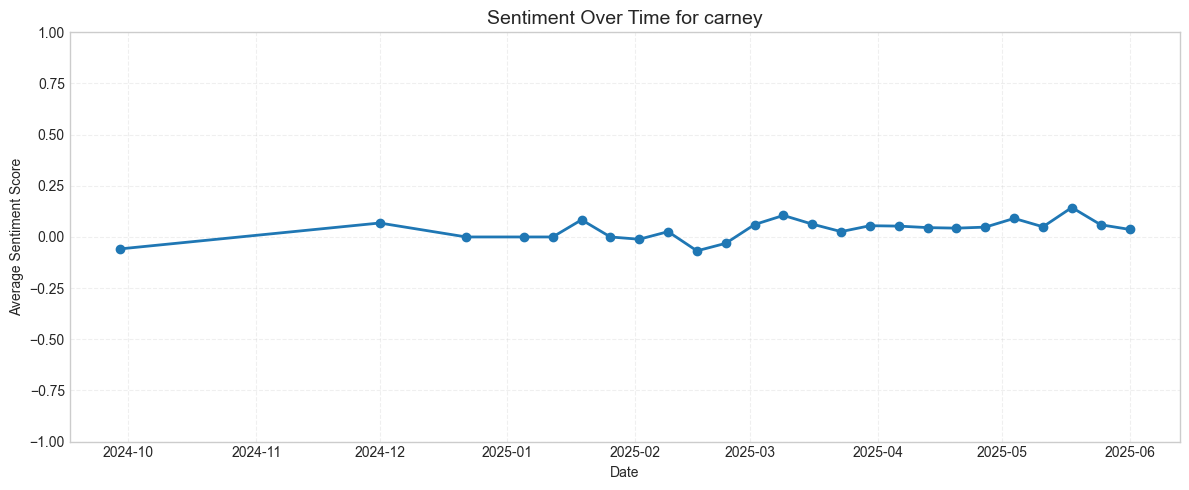

In [ ]:
# Keep rows with at least one person
df_people = election_submissions[election_submissions['people'] != ""]

# Split comma-separated people and explode
df_people = df_people.assign(person=df_people['people'].str.split(', ')).explode('person')

# Remove empty strings
df_people = df_people[df_people['person'] != ""]

# Ensure datetime
df_people['created_utc'] = pd.to_datetime(df_people['created_utc'])

# Get top 5 most mentioned people
top_people = df_people['person'].value_counts().head(5).index.tolist()

# Filter for top 5
df_top = df_people[df_people['person'].isin(top_people)]
# Aggregate average sentiment per day
sentiment_grouped = (
    df_top.groupby([pd.Grouper(key='created_utc', freq='w'), 'person'])
    .agg(avg_sentiment=('sentiment_score', 'mean'))
    .reset_index()
)

for person in top_people:
    df_person = sentiment_grouped[sentiment_grouped['person'] == person]
    
    plt.figure(figsize=(12,5))
    plt.plot(df_person['created_utc'], df_person['avg_sentiment'], marker='o', linewidth=2)
    plt.title(f"Sentiment Over Time for {person}", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Average Sentiment Score")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.ylim(-1, 1)  # Sentiment score range
    plt.tight_layout()
    plt.show()


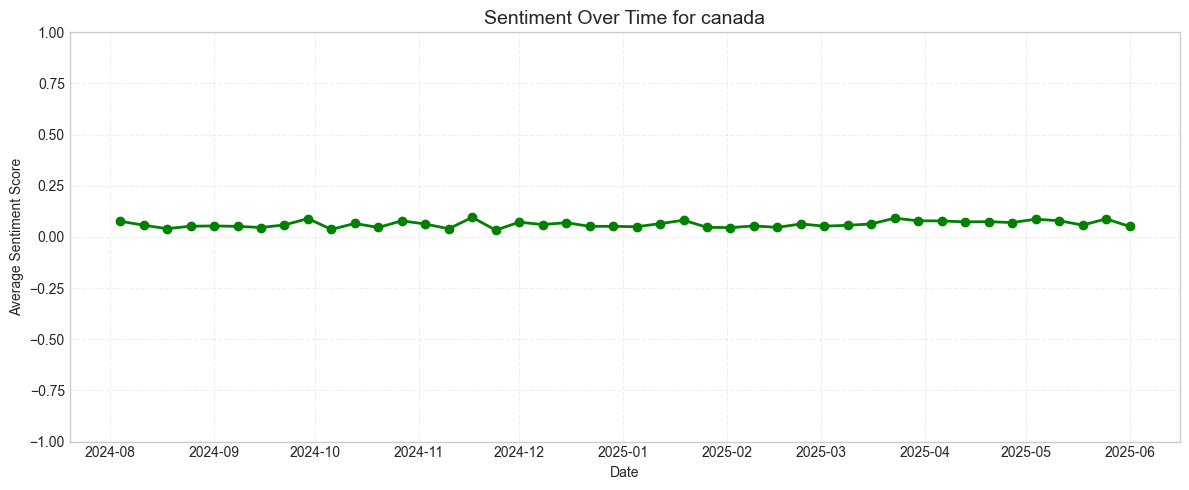

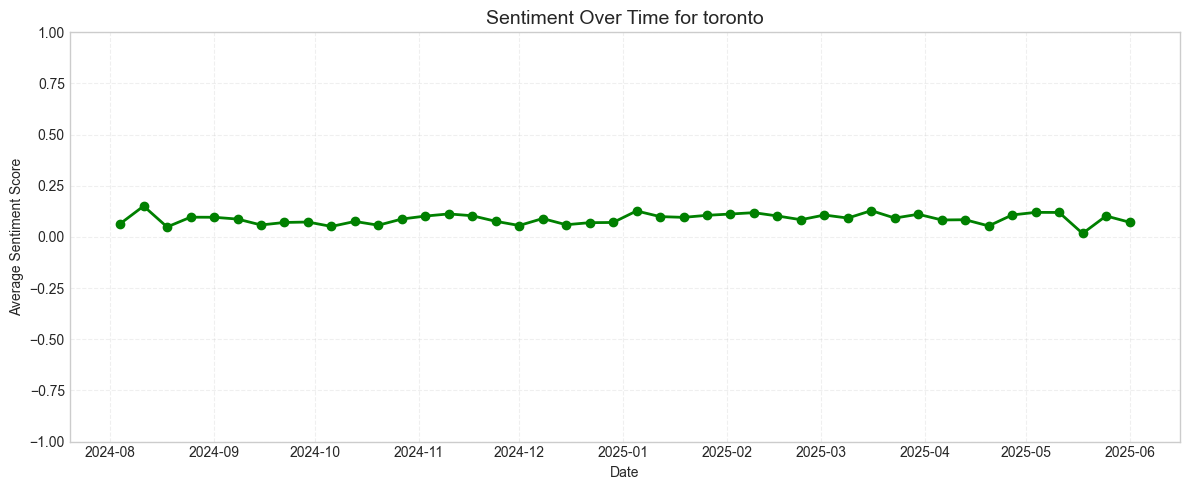

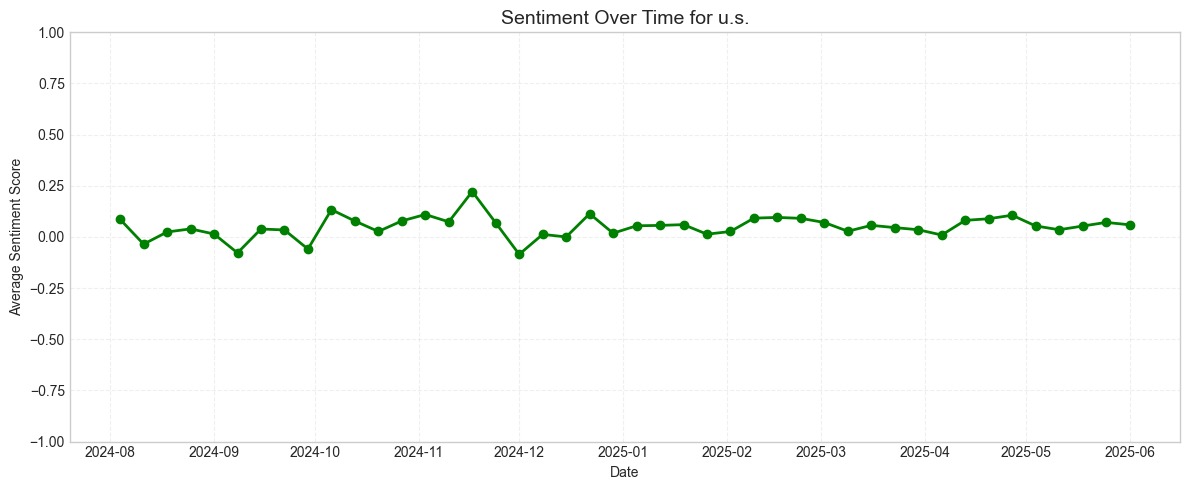

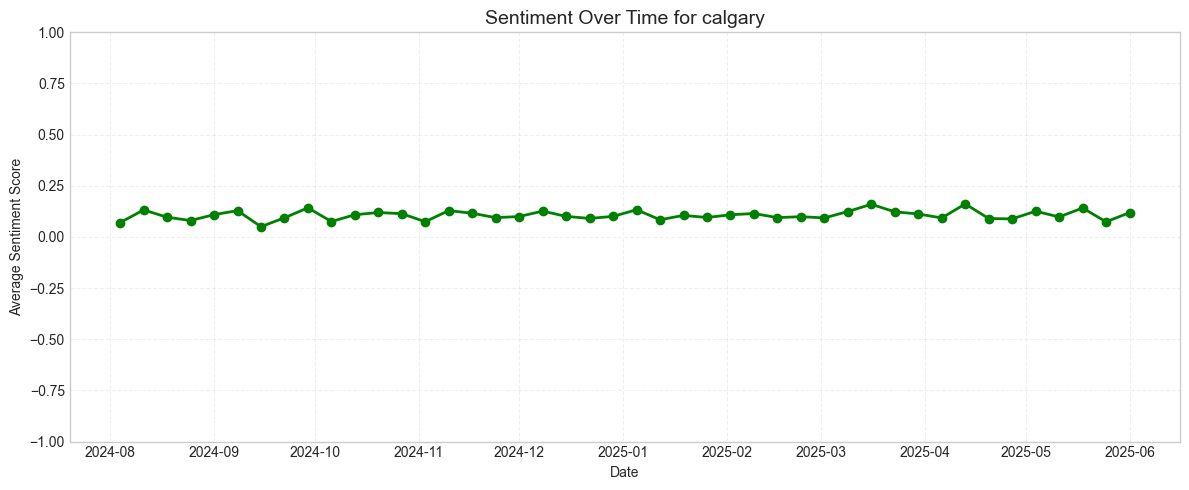

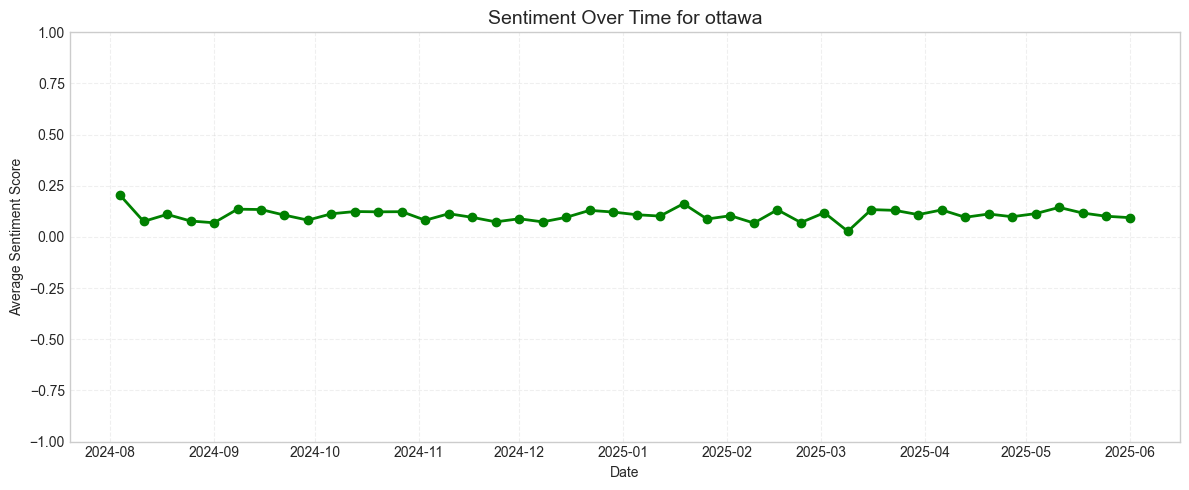

In [ ]:
# Keep rows with at least one place
df_places = election_submissions[election_submissions['places'] != ""]

# Split comma-separated places and explode
df_places = df_places.assign(place=df_places['places'].str.split(', ')).explode('place')

# Remove empty strings
df_places = df_places[df_places['place'] != ""]

# Ensure datetime
df_places['created_utc'] = pd.to_datetime(df_places['created_utc'])

# Get top 5 most mentioned places
top_places = df_places['place'].value_counts().head(5).index.tolist()

# Filter for top 5
df_top_places = df_places[df_places['place'].isin(top_places)]
# Aggregate average sentiment per day
sentiment_grouped_places = (
    df_top_places.groupby([pd.Grouper(key='created_utc', freq='W'), 'place'])
    .agg(avg_sentiment=('sentiment_score', 'mean'))
    .reset_index()
)

for place in top_places:
    df_place = sentiment_grouped_places[sentiment_grouped_places['place'] == place]
    
    plt.figure(figsize=(12,5))
    plt.plot(df_place['created_utc'], df_place['avg_sentiment'], marker='o', linewidth=2, color='green')
    plt.title(f"Sentiment Over Time for {place}", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Average Sentiment Score")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.ylim(-1, 1)  # Sentiment score range
    plt.tight_layout()
    plt.show()
